In [2]:
CLASS_MAP = {
    'car': 1,
    'man': 2,
    'cat': 3
}



In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

!pip install -q torchvision xmltodict

import os
import numpy as np
import xmltodict
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [5]:
import os
import xmltodict
import torch
from PIL import Image
from torch.utils.data import Dataset

class ThermalDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.imgs = sorted(os.listdir(img_dir))

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        ann_path = os.path.join(self.ann_dir, img_name.replace('.jpg', '.xml'))

        image = Image.open(img_path).convert("RGB")

        with open(ann_path) as f:
            ann = xmltodict.parse(f.read())['annotation']

        boxes, labels = [], []
        objects = ann.get('object', [])
        if isinstance(objects, dict):
            objects = [objects]

        for obj in objects:
            label_name = obj['name'].lower()
            if label_name not in CLASS_MAP:
                continue

            label = CLASS_MAP[label_name]
            bbox = obj['bndbox']
            x1, y1 = float(bbox['xmin']), float(bbox['ymin'])
            x2, y2 = float(bbox['xmax']), float(bbox['ymax'])

            if x2 <= x1 or y2 <= y1:
                print(f"⚠️ Skipping invalid box in {img_name}: {x1, y1, x2, y2}")
                continue

            boxes.append([x1, y1, x2, y2])
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.imgs)


In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


In [7]:
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Transforms
transform = T.Compose([T.ToTensor()])

# Dataset paths
img_dir = '/content/drive/MyDrive/thermal_data/images'
ann_dir = '/content/drive/MyDrive/thermal_data/annotations'

# Dataset & DataLoader
dataset = ThermalDataset(img_dir, ann_dir, transforms=transform)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [8]:
model = get_model(num_classes=4)  # car, man, cat + background
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"\n Epoch [{epoch+1}/{num_epochs}]")

    for batch_idx, (images, targets) in enumerate(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        print(f"  ✅ Batch {batch_idx+1}/{len(data_loader)} - Loss: {losses.item():.4f}")

    lr_scheduler.step()
    print(f"✅ Epoch [{epoch+1}/{num_epochs}] Finished - Total Loss: {running_loss:.4f}")



⏳ Epoch [1/5]
  ✅ Batch 1/34 - Loss: 1.9733
  ✅ Batch 2/34 - Loss: 0.7058
  ✅ Batch 3/34 - Loss: 0.4475
  ✅ Batch 4/34 - Loss: 0.3020
  ✅ Batch 5/34 - Loss: 0.3075
  ✅ Batch 6/34 - Loss: 0.4807
  ✅ Batch 7/34 - Loss: 0.4503
  ✅ Batch 8/34 - Loss: 0.5028
  ✅ Batch 9/34 - Loss: 0.2560
  ✅ Batch 10/34 - Loss: 0.1985
  ✅ Batch 11/34 - Loss: 0.2105
  ✅ Batch 12/34 - Loss: 0.2300
  ✅ Batch 13/34 - Loss: 0.3033
  ✅ Batch 14/34 - Loss: 0.1957
  ✅ Batch 15/34 - Loss: 0.2481
  ✅ Batch 16/34 - Loss: 0.3026
  ✅ Batch 17/34 - Loss: 0.2004
  ✅ Batch 18/34 - Loss: 0.2331
  ✅ Batch 19/34 - Loss: 0.2200
  ✅ Batch 20/34 - Loss: 0.2508
  ✅ Batch 21/34 - Loss: 0.2453
  ✅ Batch 22/34 - Loss: 0.1584
  ✅ Batch 23/34 - Loss: 0.2309
  ✅ Batch 24/34 - Loss: 0.2522
  ✅ Batch 25/34 - Loss: 0.1933
  ✅ Batch 26/34 - Loss: 0.2314
  ✅ Batch 27/34 - Loss: 0.1434
  ✅ Batch 28/34 - Loss: 0.4539
  ✅ Batch 29/34 - Loss: 0.2861
  ✅ Batch 30/34 - Loss: 0.3139
  ✅ Batch 31/34 - Loss: 0.2466
  ✅ Batch 32/34 - Loss: 0.2051
  

In [10]:
# Save
torch.save(model.state_dict(), '/content/drive/MyDrive/fasterrcnn_thermal_model.pth')

# Later (to load for inference)
model = get_model(num_classes=4)
model.load_state_dict(torch.load('/content/drive/MyDrive/fasterrcnn_thermal_model.pth'))
model.to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

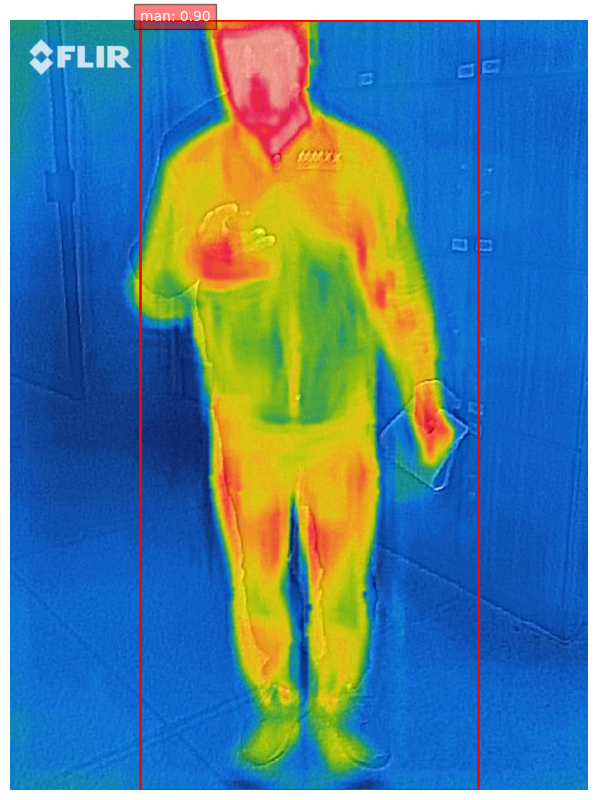

In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def predict_and_visualize(image_path, model, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    img_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    id_to_label = {v: k for k, v in CLASS_MAP.items()}

    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if score >= threshold:
            x1, y1, x2, y2 = box
            ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                       fill=False, edgecolor='red', linewidth=2))
            label_name = id_to_label.get(label.item(), "unknown")
            ax.text(x1, y1, f"{label_name}: {score:.2f}", color='white',
                    bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()


predict_and_visualize('/content/drive/MyDrive/flir images/TEST/Test_man_36.jpg', model)


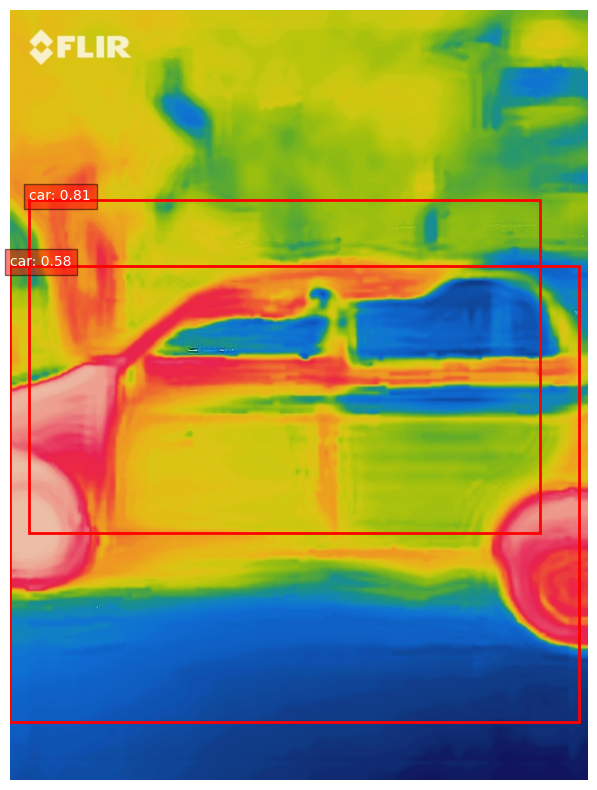

In [13]:
predict_and_visualize('/content/drive/MyDrive/flir images/TEST/Test_car_25.jpg', model)

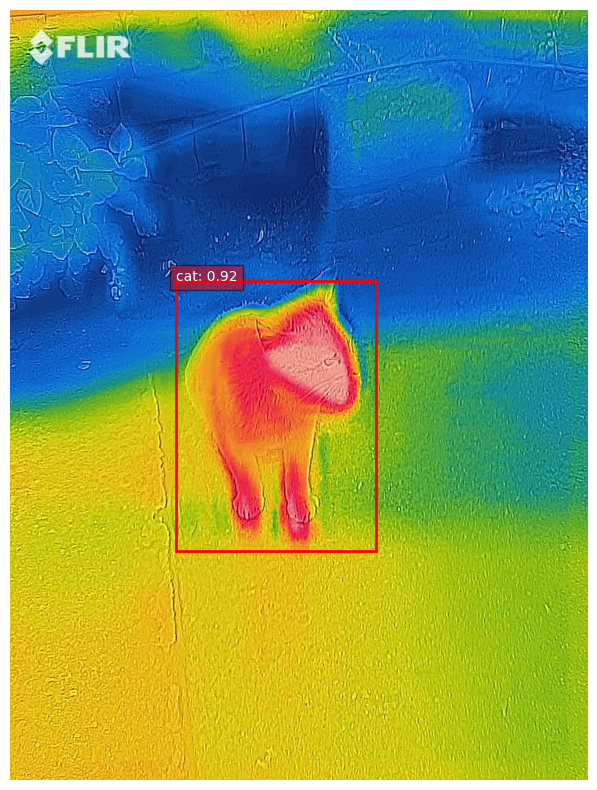

In [14]:
predict_and_visualize('/content/drive/MyDrive/flir images/TEST/Test_cat_40.jpg', model)

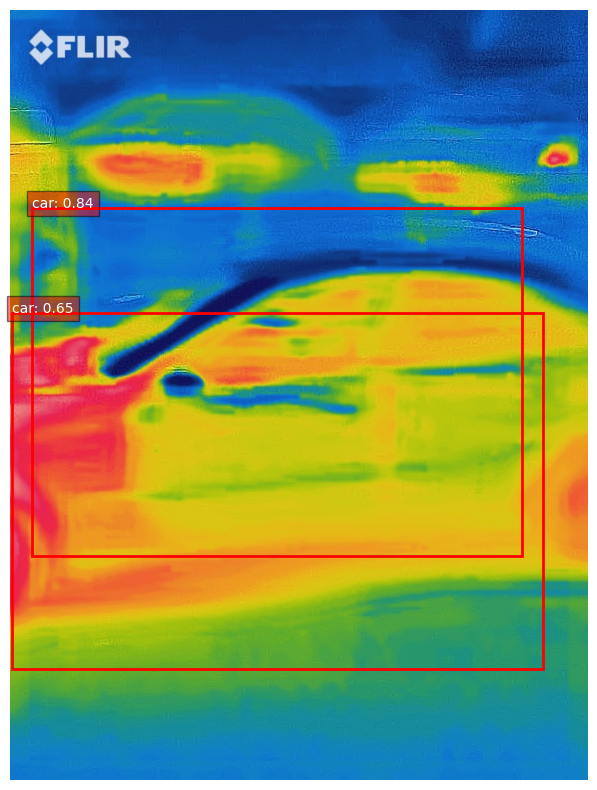

In [22]:
predict_and_visualize('/content/drive/MyDrive/thermal_data_test/images/Test_car_13.jpg', model)

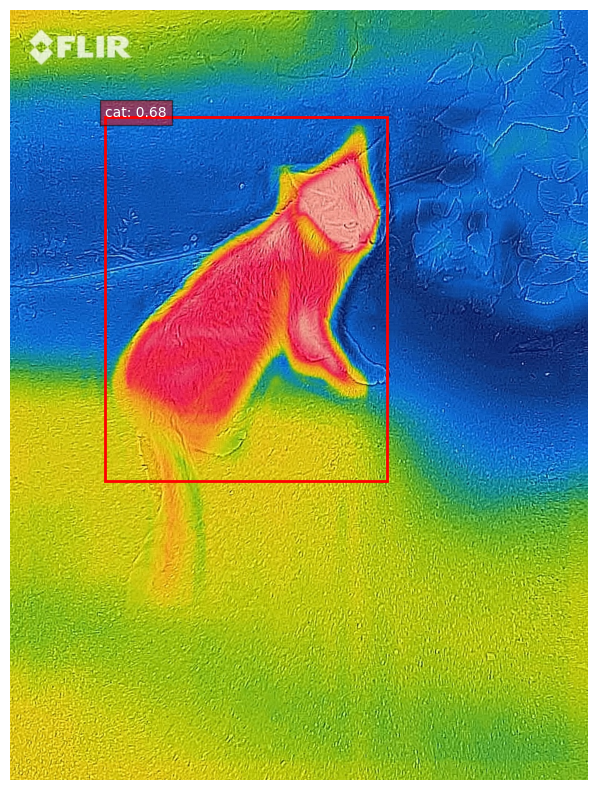

In [27]:
predict_and_visualize('/content/drive/MyDrive/thermal_data_test/images/Test_cat_69.jpg', model)

📊 Mean IoU: 0.4138
📊 Mean Precision: 1.0000
📊 Mean Recall: 0.1593
📊 mAP: 1.0000


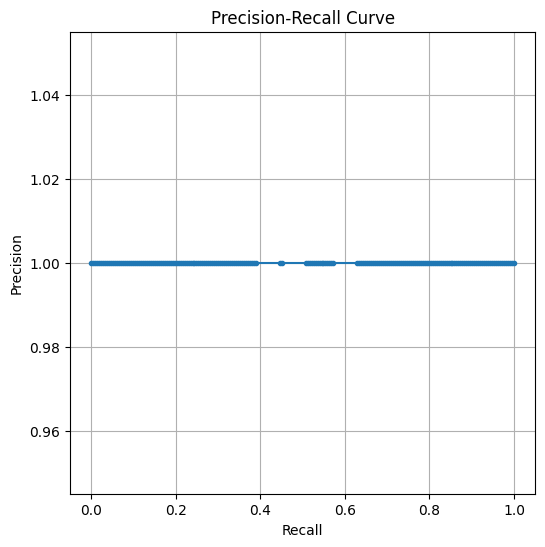

In [ ]:
from sklearn.metrics import precision_score, recall_score, average_precision_score
import numpy as np

# ===== 1. Load Test Dataset =====
test_img_dir = '/content/drive/MyDrive/thermal_data_test/images'
test_ann_dir = '/content/drive/MyDrive/thermal_data_test/annotations'
test_dataset = ThermalDataset(test_img_dir, test_ann_dir, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# ===== 2. IoU Calculation =====
def calculate_iou(boxA, boxB):
    # Box format: [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

# ===== 3. Evaluation Metrics =====
all_precisions, all_recalls, all_ious, y_true_all, y_score_all = [], [], [], [], []

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)
        outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]

        gt_boxes = targets[0]['boxes'].cpu().numpy()
        pred_boxes = outputs[0]['boxes'].cpu().numpy()
        pred_scores = outputs[0]['scores'].cpu().numpy()
        pred_labels = outputs[0]['labels'].cpu().numpy()
        gt_labels = targets[0]['labels'].cpu().numpy()

        # Calculate IoU for each prediction
        for pb in pred_boxes:
            best_iou = 0
            for gb in gt_boxes:
                iou = calculate_iou(pb, gb)
                best_iou = max(best_iou, iou)
            all_ious.append(best_iou)

        # Convert to binary for Precision/Recall
        y_true = []
        y_score = []
        for gt_label in gt_labels:
            y_true.append(1)  # object present

        for score in pred_scores:
            y_score.append(score)

        # If predictions exist
        if len(pred_labels) > 0:
            preds_binary = (pred_scores >= 0.5).astype(int)
            precision = precision_score([1]*len(preds_binary), preds_binary, zero_division=0)
            recall = recall_score([1]*len(preds_binary), preds_binary, zero_division=0)
        else:
            precision, recall = 0, 0

        all_precisions.append(precision)
        all_recalls.append(recall)
        y_true_all.extend([1]*len(pred_scores))
        y_score_all.extend(pred_scores)

# ===== 4. Mean metrics =====
mean_iou = np.mean(all_ious) if all_ious else 0
mean_precision = np.mean(all_precisions)
mean_recall = np.mean(all_recalls)
mAP = average_precision_score(y_true_all, y_score_all) if y_true_all else 0

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"mAP: {mAP:.4f}")

# ===== 5. Plot Precision-Recall curve =====
from sklearn.metrics import precision_recall_curve

prec_curve, rec_curve, _ = precision_recall_curve(y_true_all, y_score_all)
plt.figure(figsize=(6, 6))
plt.plot(rec_curve, prec_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


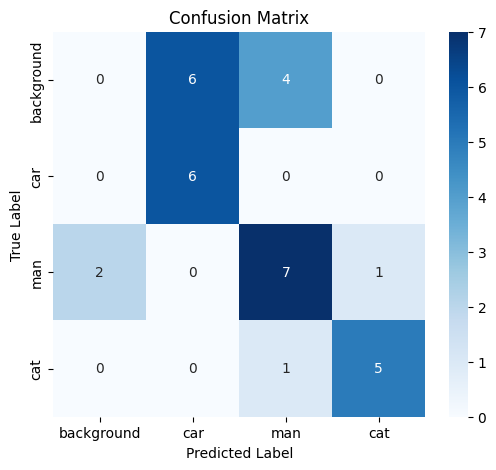

Classification Report:
              precision    recall  f1-score   support

  background       0.00      0.00      0.00        10
         car       0.50      1.00      0.67         6
         man       0.58      0.70      0.64        10
         cat       0.83      0.83      0.83         6

    accuracy                           0.56        32
   macro avg       0.48      0.63      0.53        32
weighted avg       0.43      0.56      0.48        32



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    return interArea / float(boxAArea + boxBArea - interArea + 1e-6)

all_true_labels = []
all_pred_labels = []

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        gt_boxes = targets[0]['boxes'].cpu().numpy()
        gt_labels = targets[0]['labels'].cpu().numpy()

        pred_boxes = outputs[0]['boxes'].cpu().numpy()
        pred_scores = outputs[0]['scores'].cpu().numpy()
        pred_labels = outputs[0]['labels'].cpu().numpy()

        keep = pred_scores >= 0.5
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]

        matched_pred_indices = set()

        for i, gt_box in enumerate(gt_boxes):
            best_iou = 0
            best_pred_idx = -1
            for j, pred_box in enumerate(pred_boxes):
                iou = calculate_iou(gt_box, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    best_pred_idx = j

            if best_iou >= 0.5 and best_pred_idx not in matched_pred_indices:
                all_true_labels.append(gt_labels[i])
                all_pred_labels.append(pred_labels[best_pred_idx])
                matched_pred_indices.add(best_pred_idx)
            else:
                all_true_labels.append(gt_labels[i])
                all_pred_labels.append(0)

        for j in range(len(pred_labels)):
            if j not in matched_pred_indices:
                all_true_labels.append(0)
                all_pred_labels.append(pred_labels[j])

id_to_label = {0: "background"}
id_to_label.update({v: k for k, v in CLASS_MAP.items()})

cm = confusion_matrix(all_true_labels, all_pred_labels, labels=list(id_to_label.keys()))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=id_to_label.values(),
            yticklabels=id_to_label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_true_labels, all_pred_labels, target_names=id_to_label.values()))


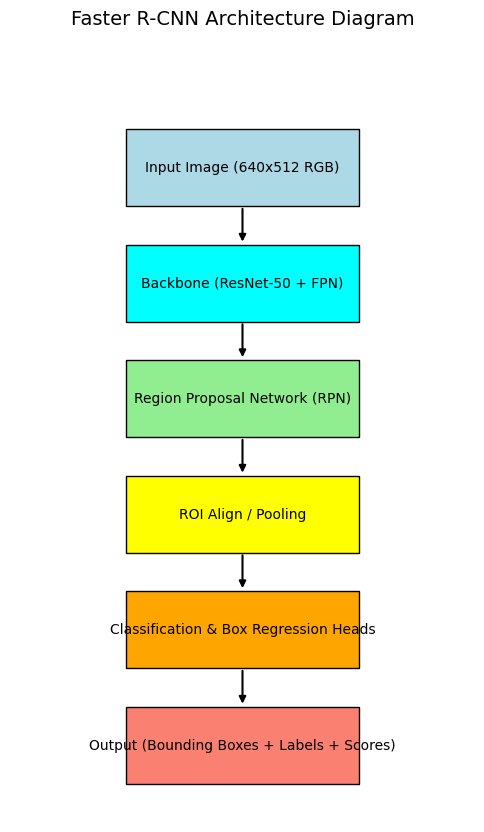

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(6, 10))

def add_box(y, text, color):
    rect = patches.Rectangle((0.25, y), 0.5, 0.1, linewidth=1, edgecolor='black', facecolor=color)
    ax.add_patch(rect)
    ax.text(0.5, y + 0.05, text, ha='center', va='center', fontsize=10, color='black')

y_positions = [0.8, 0.65, 0.5, 0.35, 0.2, 0.05]
labels = [
    "Input Image (640x512 RGB)",
    "Backbone (ResNet-50 + FPN)",
    "Region Proposal Network (RPN)",
    "ROI Align / Pooling",
    "Classification & Box Regression Heads",
    "Output (Bounding Boxes + Labels + Scores)"
]
colors = ['lightblue', 'cyan', 'lightgreen', 'yellow', 'orange', 'salmon']

for y, text, color in zip(y_positions, labels, colors):
    add_box(y, text, color)

for i in range(len(y_positions) - 1):
    start_y = y_positions[i]
    end_y = y_positions[i + 1] + 0.1
    ax.annotate('', xy=(0.5, end_y), xytext=(0.5, start_y),
                arrowprops=dict(facecolor='black', arrowstyle='-|>', lw=1.5))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

plt.title("Faster R-CNN Architecture Diagram", fontsize=14, pad=20)
plt.savefig("faster_rcnn_architecture.png", dpi=300, bbox_inches='tight')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


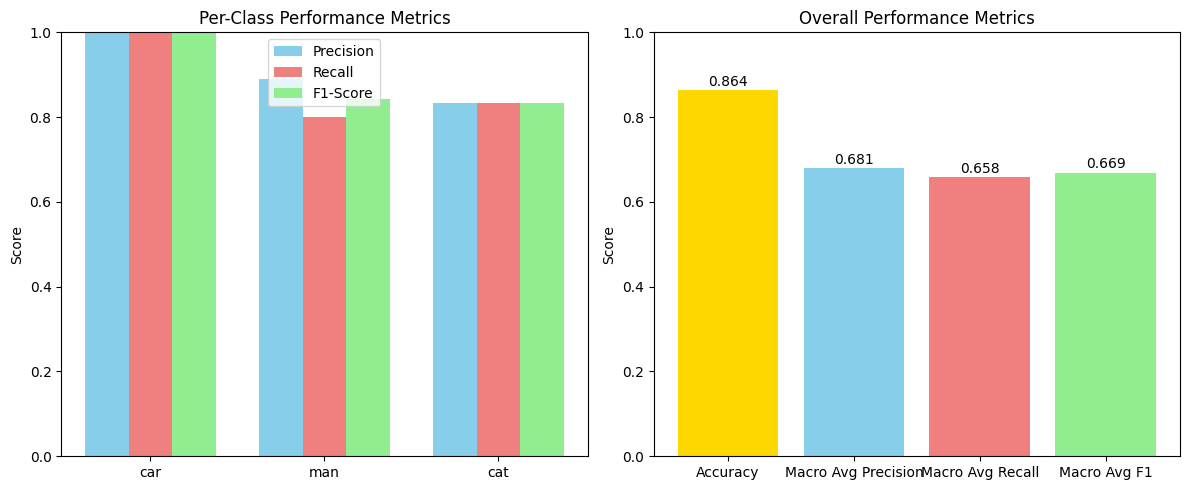

In [30]:
# Include background in names
target_names = ["background"] + list(CLASS_MAP.keys())  # e.g., ["background", "car", "cat", "man"]

# Explicit labels so sklearn knows the mapping
labels_list = list(range(len(target_names)))  # [0,1,2,3]

report = classification_report(
    y_true,
    y_pred,
    labels=labels_list,
    target_names=target_names,
    output_dict=True
)

# Remove background for per-class plotting
classes = target_names[1:]
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score_vals = [report[cls]['f1-score'] for cls in classes]

accuracy = accuracy_score(y_true, y_pred)
macro_precision = report['macro avg']['precision']
macro_recall = report['macro avg']['recall']
macro_f1 = report['macro avg']['f1-score']

# === Plot ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Per-class plot
x = np.arange(len(classes))
width = 0.25
axes[0].bar(x - width, precision, width, label='Precision', color='skyblue')
axes[0].bar(x, recall, width, label='Recall', color='lightcoral')
axes[0].bar(x + width, f1_score_vals, width, label='F1-Score', color='lightgreen')
axes[0].set_xticks(x)
axes[0].set_xticklabels(classes)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Score")
axes[0].set_title("Per-Class Performance Metrics")
axes[0].legend()

# Overall metrics plot
overall_names = ["Accuracy", "Macro Avg Precision", "Macro Avg Recall", "Macro Avg F1"]
overall_scores = [accuracy, macro_precision, macro_recall, macro_f1]
colors = ['gold', 'skyblue', 'lightcoral', 'lightgreen']
bars = axes[1].bar(overall_names, overall_scores, color=colors)

for bar, score in zip(bars, overall_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{score:.3f}", ha='center', fontsize=10)

axes[1].set_ylim(0, 1)
axes[1].set_ylabel("Score")
axes[1].set_title("Overall Performance Metrics")

plt.tight_layout()
plt.show()
